# Classification Model Bake-off
- The goal is to create a model that best predicts whether or not a person will default on their bank loan. 
- In doing so, we want to utilize all of the different tools we have learned over the course: data cleaning, EDA, feature engineering/transformation, feature selection, hyperparameter tuning, and model evaluation. 
- You will fit **three different models** (KNN, Logistic Regression, and Decision Tree Classifier) to predict credit card defaults 
- Use gridsearch to find the best hyperparameters for those models. Then you will compare the performance of those three models on a test set to find the best one.  
- We will be scoring the submitted predictions using the **F1 score.**

## Process/Expectations

1. Clean up your data set so that you can perform an EDA. 
    - This includes handling null values, categorical variables, removing unimportant columns, and removing outliers.
2. Perform EDA to identify opportunities to create new features.
    - [Great Example of EDA for classification](https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end) 
    - [Using Pairplots with Classification](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
3. Engineer new features. 
    - Create polynomial and/or interaction features. 
    - Additionaly, you must also create **at least 2 new features** that are not interactions or polynomial transformations. 
        - *For example, you can create a new dummy variable that based on the value of a continuous variable (billamount6 >2000) or take the average of some past amounts.*
4. Perform some feature selection. 
5. You must fit **three** models to your data and tune **at least 1 hyperparameter** per model. 
6. Using the F-1 Score, evaluate how well your models perform and identify your best model.
7. Using information from your EDA process and your model(s) output provide insight as to which borrowers are more likely to deafult


In [92]:
# import libraries
import pandas as pd
pd.options.display.max_columns = 50
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV, SelectKBest, f_regression
from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
import pickle

## 1. Data Cleaning

In [93]:
df = pd.read_csv('training_data.csv', index_col=0)
# index_col=0 prevents generating that 'Unnamed:0' column

In [94]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
28835,220000,2,1,2,36,0,0,0,0,0,0,222598,222168,217900,221193,181859,184605,10000,8018,10121,6006,10987,143779,1
25329,200000,2,3,2,29,-1,-1,-1,-1,-1,-1,326,326,326,326,326,326,326,326,326,326,326,326,0
18894,180000,2,1,2,27,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0
690,80000,1,2,2,32,0,0,0,0,0,0,51372,51872,47593,43882,42256,42527,1853,1700,1522,1548,1488,1500,0
6239,10000,1,2,2,27,0,0,0,0,0,0,8257,7995,4878,5444,2639,2697,2000,1100,600,300,300,1000,1


In [95]:
# making dataframe mor readable by creating new column names
rename_list = ['max_credit_given', 'gender', 'education', 'marital_status', 'age',
'pay_status_sept', 'pay_status_aug', 'pay_status_july', 'pay_status_june', 'pay_status_may', 'pay_status_april', 
'bill_sept', 'bill_aug', 'bill_july', 'bill_june', 'bill_may', 'bill_april',
'payment_sep', 'payment_aug', 'payments_jul', 'payment_jun', 'payment_may', 'payment_april', 'default']
col_rename = dict(zip(df.columns,rename_list))
df = df.rename(columns=col_rename)

In [96]:
# checking that it worked
df.head()

,max_credit_given,gender,education,marital_status,age,pay_status_sept,pay_status_aug,pay_status_july,pay_status_june,pay_status_may,pay_status_april,bill_sept,bill_aug,bill_july,bill_june,bill_may,bill_april,payment_sep,payment_aug,payments_jul,payment_jun,payment_may,payment_april,default
28835,220000,2,1,2,36,0,0,0,0,0,0,222598,222168,217900,221193,181859,184605,10000,8018,10121,6006,10987,143779,1
25329,200000,2,3,2,29,-1,-1,-1,-1,-1,-1,326,326,326,326,326,326,326,326,326,326,326,326,0
18894,180000,2,1,2,27,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0
690,80000,1,2,2,32,0,0,0,0,0,0,51372,51872,47593,43882,42256,42527,1853,1700,1522,1548,1488,1500,0
6239,10000,1,2,2,27,0,0,0,0,0,0,8257,7995,4878,5444,2639,2697,2000,1100,600,300,300,1000,1


In [97]:
df.iloc[18381]

max_credit_given                     LIMIT_BAL
gender                                     SEX
education                            EDUCATION
marital_status                        MARRIAGE
age                                        AGE
pay_status_sept                          PAY_0
pay_status_aug                           PAY_2
pay_status_july                          PAY_3
pay_status_june                          PAY_4
pay_status_may                           PAY_5
pay_status_april                         PAY_6
bill_sept                            BILL_AMT1
bill_aug                             BILL_AMT2
bill_july                            BILL_AMT3
bill_june                            BILL_AMT4
bill_may                             BILL_AMT5
bill_april                           BILL_AMT6
payment_sep                           PAY_AMT1
payment_aug                           PAY_AMT2
payments_jul                          PAY_AMT3
payment_jun                           PAY_AMT4
payment_may  

In [98]:
df.shape

(22500, 24)

In [99]:
# drop the row if has text in it
df.drop(df[df.gender == 'SEX'].index, inplace=True)

In [100]:
# checking that worked
df.shape

(22499, 24)

#### now that the row with column names is gone, we can convert the entire dataframe from objects to float/int

In [101]:
# checking data types
df.info()
# theyre all objects, we need to change this

<class 'pandas.core.frame.DataFrame'>
Index: 22499 entries, 28835 to 7624
Data columns (total 24 columns):
max_credit_given    22499 non-null object
gender              22499 non-null object
education           22499 non-null object
marital_status      22499 non-null object
age                 22499 non-null object
pay_status_sept     22499 non-null object
pay_status_aug      22499 non-null object
pay_status_july     22499 non-null object
pay_status_june     22499 non-null object
pay_status_may      22499 non-null object
pay_status_april    22499 non-null object
bill_sept           22499 non-null object
bill_aug            22499 non-null object
bill_july           22499 non-null object
bill_june           22499 non-null object
bill_may            22499 non-null object
bill_april          22499 non-null object
payment_sep         22499 non-null object
payment_aug         22499 non-null object
payments_jul        22499 non-null object
payment_jun         22499 non-null object
payment_may

In [102]:
# changing all values from objects to
df = df.apply(pd.to_numeric, errors='coerce')

In [103]:
# checking data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22499 entries, 28835 to 7624
Data columns (total 24 columns):
max_credit_given    22499 non-null int64
gender              22499 non-null int64
education           22499 non-null int64
marital_status      22499 non-null int64
age                 22499 non-null int64
pay_status_sept     22499 non-null int64
pay_status_aug      22499 non-null int64
pay_status_july     22499 non-null int64
pay_status_june     22499 non-null int64
pay_status_may      22499 non-null int64
pay_status_april    22499 non-null int64
bill_sept           22499 non-null int64
bill_aug            22499 non-null int64
bill_july           22499 non-null int64
bill_june           22499 non-null int64
bill_may            22499 non-null int64
bill_april          22499 non-null int64
payment_sep         22499 non-null int64
payment_aug         22499 non-null int64
payments_jul        22499 non-null int64
payment_jun         22499 non-null int64
payment_may         22499 non-nu

### Fixing 3 main categorical variables

In [104]:
# Categorical variables description
df[['gender', 'education', 'marital_status']].describe()

,gender,education,marital_status
count,22499.000000,22499.000000,22499.000000
mean,1.603227,1.855282,1.553358
std,0.489239,0.791905,0.521418
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000
max,2.000000,6.000000,3.000000


In [105]:
# Next deal with- why are there other educations besides 1-4 ??
df['education'].value_counts()

2    10516
1     7919
3     3713
5      208
4       90
6       42
0       11
Name: education, dtype: int64

- 'education' has category 5 and 6 that are unlabeled, and the category 0 is undocumented.
- 'marital_status' has a label 0 that is undocumented

They just put the weird values in the 'other' categories. is this safe to do?
let's check to see what other people did first
- 'other' in education can be an education lower than the high school level.
- 'other' in marital_status could be, for example, "divorced".

In [106]:
# fixing 'education' column by putting unknown variables in 'other' category (4)
fix_edu = (df.education == 5) | (df.education == 6) | (df.education == 0)
df.loc[fix_edu, 'education'] = 4

# fixing 'marital_status' column
df.loc[df.marital_status == 0, 'marital_status'] = 3

In [107]:
df.education.value_counts()

2    10516
1     7919
3     3713
4      351
Name: education, dtype: int64

In [108]:
df.marital_status.value_counts()

2    12026
1    10195
3      278
Name: marital_status, dtype: int64

## Checking for irregularities, by column groups



### checking History of Past Payment (payment delay)

In [113]:
# this should be on a scale from -1, 1-9
# -1 being 'pay duly' and 1-9 being how many months of payment delay

df[['pay_status_sept', 'pay_status_aug', 'pay_status_july', 'pay_status_june', 'pay_status_may', 'pay_status_april']].describe()

,pay_status_sept,pay_status_aug,pay_status_july,pay_status_june,pay_status_may,pay_status_april
count,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000
mean,-0.014090,-0.128806,-0.160185,-0.214587,-0.259700,-0.287613
std,1.123191,1.197954,1.198880,1.174824,1.139984,1.154249
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


- There shouldn't be any -2 here, so let's just set it to 'pay duly' as if there wasn't any delay
- and 'pay duly' should probably just be 0 instead of -1 because that means the payment wasn't delayed

In [128]:
fix_status = (df.pay_status_sept == -2) | (df.pay_status_sept == -1) | (df.pay_status_sept == 0)
df.loc[fix_status, 'pay_status_sept'] = 0

fix_status = (df.pay_status_aug == -2) | (df.pay_status_aug == -1) | (df.pay_status_aug == 0)
df.loc[fix_status, 'pay_status_aug'] = 0

fix_status = (df.pay_status_july == -2) | (df.pay_status_july == -1) | (df.pay_status_july == 0)
df.loc[fix_status, 'pay_status_july'] = 0

fix_status = (df.pay_status_june == -2) | (df.pay_status_june == -1) | (df.pay_status_june == 0)
df.loc[fix_status, 'pay_status_june'] = 0

fix_status = (df.pay_status_may == -2) | (df.pay_status_may == -1) | (df.pay_status_may == 0)
df.loc[fix_status, 'pay_status_may'] = 0

fix_status = (df.pay_status_april == -2) | (df.pay_status_april == -1) | (df.pay_status_april == 0)
df.loc[fix_status, 'pay_status_april'] = 0

### checking amount of bill statement

In [115]:
# checking amount of bill statement
df[['bill_sept', 'bill_aug', 'bill_july', 'bill_june', 'bill_may', 'bill_april']].describe()

,bill_sept,bill_aug,bill_july,bill_june,bill_may,bill_april
count,22499.000000,22499.000000,2.249900e+04,22499.000000,22499.000000,22499.000000
mean,51455.869416,49385.313214,4.704213e+04,43329.149562,40306.373039,38955.000356
std,74470.257248,71953.814345,6.991792e+04,64607.088483,60918.993067,59773.144959
min,-165580.000000,-69777.000000,-1.572640e+05,-81334.000000,-81334.000000,-339603.000000
25%,3506.000000,2975.000000,2.611500e+03,2319.500000,1732.500000,1230.000000
50%,22387.000000,21145.000000,2.005300e+04,19048.000000,18050.000000,16924.000000
75%,66988.500000,63755.000000,6.016100e+04,54494.500000,50196.000000,49250.000000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


- negative values can be interpreted as credit

### checking amount of previous statement

In [117]:
# checking amount of previous statement
df[['payment_sep', 'payment_aug', 'payments_jul', 'payment_jun', 'payment_may', 'payment_april']].describe()

,payment_sep,payment_aug,payments_jul,payment_jun,payment_may,payment_april
count,22499.000000,2.249900e+04,22499.000000,22499.000000,22499.000000,22499.000000
mean,5627.914796,5.964393e+03,5258.912307,4792.971777,4865.656029,5247.279301
std,16628.162287,2.444370e+04,18153.554633,15872.858180,15507.449610,17892.327398
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1000.000000,8.290000e+02,396.000000,284.000000,246.500000,100.000000
50%,2100.000000,2.004000e+03,1800.000000,1500.000000,1500.000000,1500.000000
75%,5002.000000,5.000000e+03,4500.000000,4000.000000,4068.500000,4000.000000
max,873552.000000,1.684259e+06,896040.000000,621000.000000,388071.000000,528666.000000


## 2: Data Visualization & EDA
#### Check cleaning_EDA.ipynb for full EDA process

### checking the amount of credit given to each person

In [119]:
# checking the amount of credit given to each person
df.max_credit_given.describe()

count      22499.000000
mean      167054.521534
std       129864.960118
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: max_credit_given, dtype: float64

In [120]:
# general idea of the default probablity for this dataset?
df.default.sum() / len(df.default)

0.22347659895995378

#### ^ This will be the same when we check class imabalance later

## 3. Feature Engineering

## 4. Train-Test Split
### Preparing data for TTS

In [123]:
# Split data to be used in the models
# Create matrix of features
X = df.drop('default', axis = 1) # grabs everything else but 'Survived'

# Create target variable
y = df['default'] # y is the column we're trying to predict

### Checking for class imbalance in 'default' column

In [124]:
df.default.value_counts()
# this means that there is a class imbalance!!

0    17471
1     5028
Name: default, dtype: int64

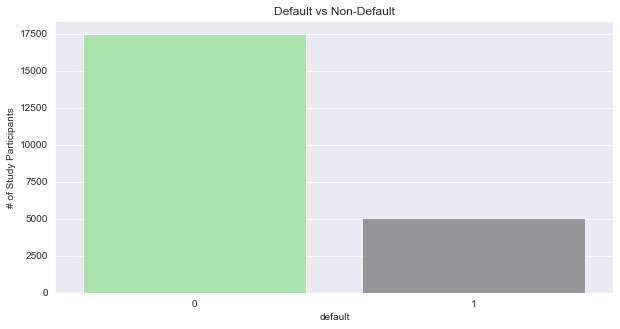

In [125]:
sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(y, alpha =.80, palette= ['lightgreen','grey'])
plt.title('Default vs Non-Default')
plt.ylabel('# of Study Participants')
plt.show()

### ^need to deal with this class imbalance first
idk if this applies here, but just know that scaling happens after TTS!

In [127]:
# performing the TTS
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=45)

# need to check how the rest of this code is ??
# look back at lecture examples!

## 5. Model Fitting and Hyperparameter Tuning
KNN, Logistic Regression, Decision Tree

In [ ]:
# Model 1: KNN

In [ ]:
# Model 2: Logisitic Regression

In [ ]:
# Model 3: Decision Tree

### Feature Selection
Does this step actually go here? check other people's notebooks

## 6. Model Evaluation

## 7. Final Model